In [1]:
import leafcutter
import torch
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import pyro.distributions as dist
import leafcutter.differential_splicing.bayes_glm
from importlib import reload
reload(leafcutter.differential_splicing.bayes_glm)

/home/david/venvs/raytune/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'leafcutter.differential_splicing.bayes_glm' from '/home/david/tealeaf/leafcutter2_testing/leafcutter/differential_splicing/bayes_glm.py'>

In [2]:
torch.manual_seed(2)
x_null, x_full, y, n, is_full, b = leafcutter.differential_splicing.bayes_glm.simulate_data()

Fitting null model


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 312.24it/s]


Fitting full model


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 312.63it/s]


Fitting spike and slab joint model


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 169.87it/s]


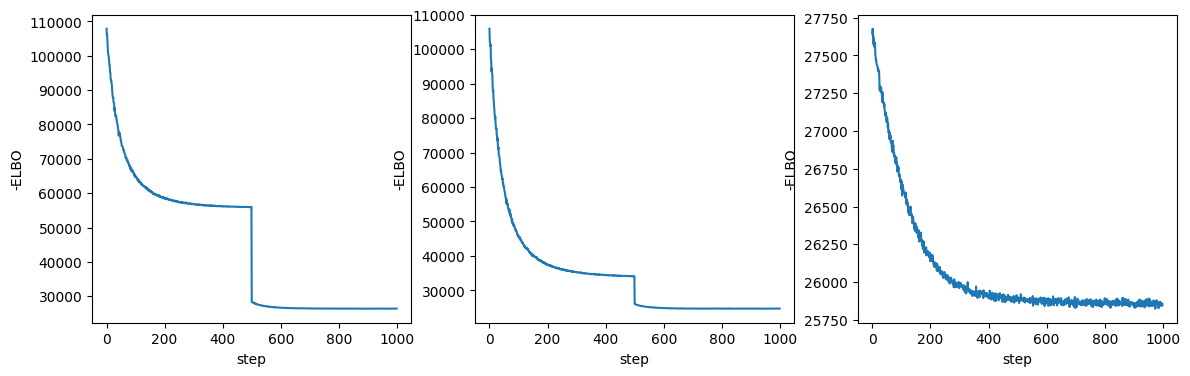

In [11]:
sas = leafcutter.differential_splicing.bayes_glm.SpikeAndSlabModel(per_hyp_conc = True)
losses_null, losses_full, losses = sas.fit(x_null, x_full, y, n, alpha = 1., iterations = 1000)

plt.figure(figsize = (14,4))
plt.subplot(1,3,1)
plt.plot(losses_null)
plt.xlabel("step")
plt.ylabel("-ELBO")

plt.subplot(1,3,2)
plt.plot(losses_full)
plt.xlabel("step")
plt.ylabel("-ELBO")

plt.subplot(1,3,3)
plt.plot(losses)
plt.xlabel("step")
plt.ylabel("-ELBO");

In [12]:
medians = sas.guide.median()
torch.corrcoef(torch.stack([medians["beta_full"].flatten(), b.flatten()]))[0,1].item()

0.510967493057251

In [13]:
post_map = sas.get_posterior_map(x_null, x_full, y, n)

In [14]:
from sklearn.metrics import roc_auc_score, average_precision_score
auroc = roc_auc_score(is_full, post_map)
aupr = average_precision_score(is_full, post_map)
auroc, aupr

(0.6987698769876989, 0.7549953682572184)

In [15]:
logw, pi = sas.get_importance_sampling_weights(x_null, x_full, y, n)

In [16]:
prob_vi = leafcutter.differential_splicing.bayes_glm.estimate_marginal_posterior(logw, 1., pi = pi)
prob_is = leafcutter.differential_splicing.bayes_glm.estimate_marginal_posterior(logw, 0., pi = pi) 
prob_m1 = leafcutter.differential_splicing.bayes_glm.estimate_marginal_posterior(logw, -1., pi = pi) 

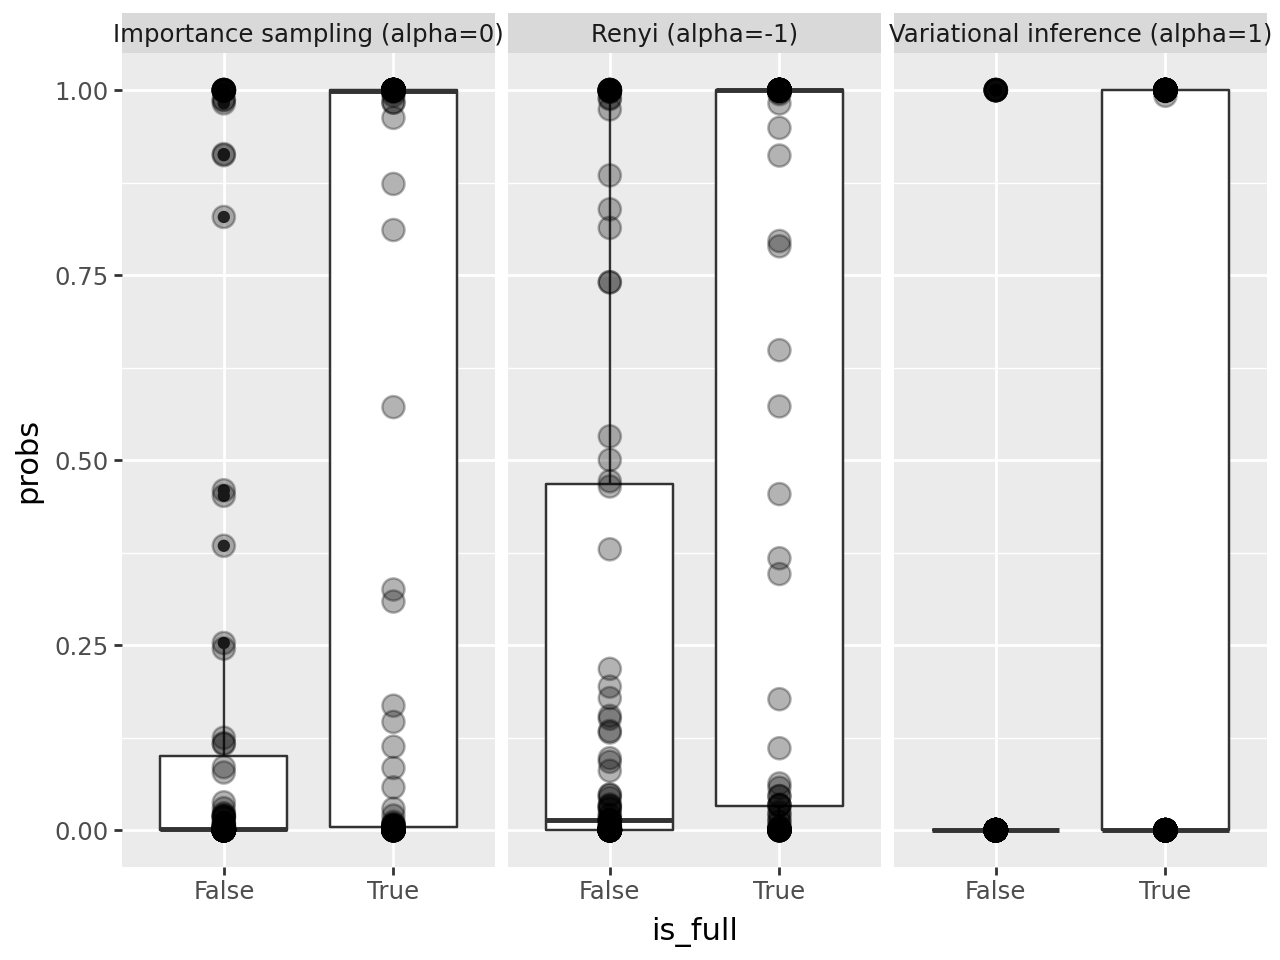

In [17]:
import plotnine as p9
import pandas as pd

df3 = pd.DataFrame({"probs": prob_is.detach().numpy(),
                    "is_full": is_full.numpy(),
                    "source": "Importance sampling (alpha=0)"})

df2 = pd.DataFrame({"probs": prob_vi.detach().numpy(),
                    "is_full": is_full.numpy(),
                    "source": "Variational inference (alpha=1)"})

df1 = pd.DataFrame({"probs": prob_m1.detach().numpy(),
                    "is_full": is_full.numpy(),
                    "source": "Renyi (alpha=-1)"})

df_combined = pd.concat([df1, df2, df3])

(p9.ggplot(df_combined, p9.aes(x="is_full", y="probs")) 
        + p9.geom_boxplot() 
        + p9.geom_point(alpha=0.3, size=4) 
        + p9.facet_wrap("~source", ncol=3))


In [ ]:
ess = bayes_glm.effective_sample_size(logw)
plt.hist(ess.flatten().detach(), 30)
ess.mean()

In [ ]:
thres = 0.9
auprs = {}
aurocs = {}
fdrs = {}
powers = {}
for alpha in torch.arange(-1., 1.1, 0.1):
    prob = bayes_glm.estimate_marginal_posterior(logw, alpha, pi = pi)
    aupr = average_precision_score(is_full, prob.detach())
    auprs[alpha.item()] = aupr
    auroc = roc_auc_score(is_full, prob.detach())
    aurocs[alpha.item()] = auroc
    
    hits = is_full[prob > thres]
    fdr = 1. - hits.float().mean()
    fdrs[alpha.item()] = fdr # =1-precision

    power = (prob > thres)[is_full].float().mean()
    powers[alpha.item()] = power # = recall = sensitivity

plt.figure(figsize = (19,4))
plt.subplot(1,4,1)
plt.plot(list(aurocs.keys()), list(aurocs.values()))
plt.xlabel("alpha")
plt.ylabel("AUROC")

plt.subplot(1,4,2)
plt.plot(list(auprs.keys()), list(auprs.values()))
plt.xlabel("alpha")
plt.ylabel("AUPR")

plt.subplot(1,4,3)
plt.plot(list(fdrs.keys()), list(fdrs.values()))
plt.xlabel("alpha")
plt.ylabel("FDR")

plt.subplot(1,4,4)
plt.plot(list(powers.keys()), list(powers.values()))
plt.xlabel("alpha")
plt.ylabel("Power")